In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense
import numpy as np

df = pd.read_csv(r'C:\Users\pinkpigma\pinkpigma的同步盘\KDD研二上\可解释性框架-工作\数据\patient_diagnoses2000_ndc300_with_history_delete4.csv')
# 预测第一天
x = df.iloc[:,5:5+72+2000]
y = df.iloc[:,5+72+2000:5+72+2000+300]


# 将字符串类型的数据转化为数值
from sklearn. preprocessing import LabelEncoder 
x['gender'] = LabelEncoder().fit_transform(x['gender'])
x['ethnicity'] = LabelEncoder().fit_transform(x['ethnicity'])
x['ethnicity_grouped'] = LabelEncoder().fit_transform(x['ethnicity_grouped'])
x['first_hosp_stay'] = LabelEncoder().fit_transform(x['first_hosp_stay'])


# 填补缺失值，用平均值
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
x = imp.fit_transform(x)
y = np.array(y)


# 划分数据集
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
# X_train = X_train.astype(np.float64)
# X_test = X_test.astype(np.float64)
# y_train = y_train.astype(np.int32)
# y_test = y_test.astype(np.int32)




In [2]:
# 划分数据集 9:1
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)



In [3]:
from keras import backend as K
from keras import losses
from keras.layers import Dropout
import numpy as np
import tensorflow as tf
from keras import losses
def JI(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
#     K.print_tensor(y_true, message='y_true = ')

    threshold_value = 0.3

    y_pred = K.cast(K.greater(y_pred, threshold_value), K.floatx())
#     K.print_tensor(y_pred, message='y_pred = ')
    fenzi = K.sum(y_true * y_pred, keepdims=True)
    # true_positives_sum = K.sum(true_positives, keepdims=True)
    fenmu = K.sum(K.cast((K.greater(y_true + y_pred, 0.8)), K.floatx()), keepdims=True)

    return K.mean(fenzi / fenmu, axis=-1)



def deep_model(feature_dim,label_dim, layer_num=1):

    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    model.add(Dense(512, activation='relu', input_dim=feature_dim))
    
    for i in range(layer_num):
        model.add(Dense(512, activation='relu'))
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[JI])
    return model

import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
def train_DNN(X_train,y_train,X_test,y_test,  
               callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],
               optimizer='adam', 
               metrics=[JI],
               hidden_layer_num=1,
               hidden_layer_units=256,
               batch_size=256, 
               epochs=500,
               hidden_layer_dropout = False,
               input_layer_dropout = False,
               dropout_rate = 0.2,
               use_kernel_regularizer = False,
              kernel_regularizer = keras.regularizers.l2(0.001)
               ):
    feature_dim = X_train.shape[1]
    label_dim = y_train.shape[1]
    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    if input_layer_dropout:
        model.add(Dropout(dropout_rate, input_shape=(feature_dim,)))
    else:
        model.add(Dense(hidden_layer_units, activation='relu', input_dim=feature_dim))
    for i in range(hidden_layer_num):
        if hidden_layer_dropout:
            model.add(Dropout(dropout_rate))
        if use_kernel_regularizer:
            model.add(Dense(hidden_layer_units, activation='relu',kernel_regularizer=kernel_regularizer))
        else:
            model.add(Dense(hidden_layer_units, activation='relu'))
        
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    model.summary()
    history = model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs,callbacks=callbacks_list,validation_data=(X_test,y_test), verbose=1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    JI_list = history.history['val_JI']
    print( "验证集上的最优结果是%s,对应训练轮次是%d" % (max(JI_list),JI_list.index(max(JI_list))+1) )
    return max(JI_list)




148/148 [==============================] - 1s 7ms/step - loss: 0.0943 - JI: 0.2867 - val_loss: 0.1003 - val_JI: 0.2534
Epoch 103/500
148/148 [==============================] - 1s 7ms/step - loss: 0.0937 - JI: 0.2890 - val_loss: 0.1087 - val_JI: 0.2276
Epoch 104/500
148/148 [==============================] - 1s 7ms/step - loss: 0.0943 - JI: 0.2869 - val_loss: 0.0996 - val_JI: 0.2626
Epoch 105/500
148/148 [==============================] - 1s 7ms/step - loss: 0.0945 - JI: 0.2854 - val_loss: 0.1003 - val_JI: 0.2600
Epoch 106/500
148/148 [==============================] - 1s 7ms/step - loss: 0.0934 - JI: 0.2904 - val_loss: 0.1001 - val_JI: 0.2507
Epoch 107/500
148/148 [==============================] - 1s 7ms/step - loss: 0.0940 - JI: 0.2882 - val_loss: 0.1021 - val_JI: 0.2485
Epoch 108/500
148/148 [==============================] - 1s 7ms/step - loss: 0.0945 - JI: 0.2861 - val_loss: 0.1000 - val_JI: 0.2629
Epoch 109/500
148/148 [==============================] - 1s 7ms/step - loss: 0.0948

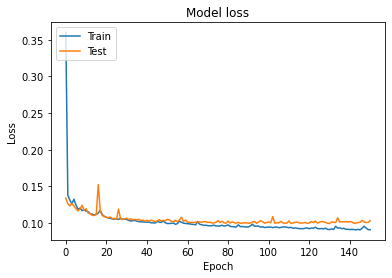

验证集上的最优结果是0.2687031626701355,对应训练轮次是143


0.2687031626701355

In [4]:
# 9:1
train_DNN(X_train,y_train,X_test,y_test)

In [7]:
# 不用72个特征
# 预测第一天
x = df.iloc[:,5+72:5+72+2000]
y = df.iloc[:,5+72+2000:5+72+2000+300]
# 划分数据集 9:1
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

create model. feature_dim =2000, label_dim =300
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               512256    
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 300)               77100     
                                                                 
Total params: 655,148
Trainable params: 655,148
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
148/148 [==============================] - 2s 10ms/step - loss: 0.2001 - JI: 0.0336 - val_loss: 0.1322 - val_JI: 0.0321
Epoch 2/500
148/148 [==============================] - 1s 8ms/step - loss: 0.1230 - JI: 0.1241 - val_loss: 0.1175 - val_JI: 0.1535
E

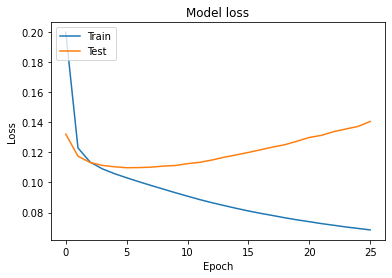

验证集上的最优结果是0.20582911372184753,对应训练轮次是10


0.20582911372184753

In [8]:
# 9:1
train_DNN(X_train,y_train,X_test,y_test)

C:\Users\PINKPI~1\AppData\Local\Temp/ipykernel_18028/890328359.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['gender'] = LabelEncoder().fit_transform(x['gender'])
C:\Users\PINKPI~1\AppData\Local\Temp/ipykernel_18028/890328359.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['ethnicity'] = LabelEncoder().fit_transform(x['ethnicity'])
C:\Users\PINKPI~1\AppData\Local\Temp/ipykernel_18028/890328359.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


create model. feature_dim =2372, label_dim =300
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               607488    
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
148/148 [==============================] - 2s 9ms/step - loss: 0.3377 - JI: 0.0598 - val_loss: 0.1339 - val_JI: 0.0745
Epoch 2/500
148/148 [==============================] - 1s 7ms/step - loss: 0.1362 - JI: 0.1062 - val_loss: 0.1344 - val_JI: 0.1217
Ep

148/148 [==============================] - 1s 8ms/step - loss: 0.0984 - JI: 0.2680 - val_loss: 0.1000 - val_JI: 0.2555
Epoch 57/500
148/148 [==============================] - 1s 8ms/step - loss: 0.0951 - JI: 0.2811 - val_loss: 0.1008 - val_JI: 0.2535
Epoch 58/500
148/148 [==============================] - 1s 7ms/step - loss: 0.0943 - JI: 0.2862 - val_loss: 0.1012 - val_JI: 0.2518
Epoch 59/500
148/148 [==============================] - 1s 7ms/step - loss: 0.0935 - JI: 0.2899 - val_loss: 0.0985 - val_JI: 0.2600
Epoch 60/500
148/148 [==============================] - 1s 7ms/step - loss: 0.0971 - JI: 0.2753 - val_loss: 0.1032 - val_JI: 0.2354
Epoch 61/500
148/148 [==============================] - 1s 7ms/step - loss: 0.0970 - JI: 0.2720 - val_loss: 0.1028 - val_JI: 0.2495
Epoch 62/500
148/148 [==============================] - 1s 7ms/step - loss: 0.0992 - JI: 0.2810 - val_loss: 0.1009 - val_JI: 0.2548
Epoch 63/500
148/148 [==============================] - 1s 9ms/step - loss: 0.0976 - JI: 

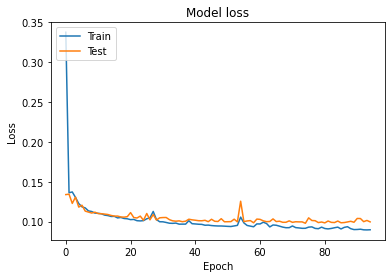

验证集上的最优结果是0.26914435625076294,对应训练轮次是90


0.26914435625076294

In [10]:
df = pd.read_csv(r'C:\Users\pinkpigma\pinkpigma的同步盘\KDD研二上\可解释性框架-工作\数据\patient_diagnoses2000_ndc300_with_history_delete4.csv')

# 用历史数据
# 预测第一天用药，过去用药当做历史信息
list1 = list(range(5,5+72+2000))+list(range(5+72+2000+600,5+72+2000+900))
x = df.iloc[:,list1]
y = df.iloc[:,5+72+2000:5+72+2000+300]
# 将字符串类型的数据转化为数值
from sklearn. preprocessing import LabelEncoder 
x['gender'] = LabelEncoder().fit_transform(x['gender'])
x['ethnicity'] = LabelEncoder().fit_transform(x['ethnicity'])
x['ethnicity_grouped'] = LabelEncoder().fit_transform(x['ethnicity_grouped'])
x['first_hosp_stay'] = LabelEncoder().fit_transform(x['first_hosp_stay'])


# 填补缺失值，用平均值
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
x = imp.fit_transform(x)
y = np.array(y)

# 划分数据集 9:1
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
# 9:1
train_DNN(X_train,y_train,X_test,y_test)